# Individual Household Electric Power Consumption

## Problem Description

Analyzing the electric power consumption can be useful for the household determining the major power utilization facilities and helping the individual household make decisions reducing power consumption based on the paterns. If the clients are renewable energy vendors, such as solar companies, a detailed analysis as well as a prediction of household power usage and the associated utility bills may be used to persuade the costomer installing their new services, such as solar panels, to reduce utility bills or even generate income. 


## Project Description

In this challenge, the electric power consumption data of an individual household is analyzed and machine learning (i.e., RNN and LSTM) is employed to predict the power consumption. The data `household_power_consumption.txt` is used for data analysis and visualization, model training and testing. A detailed data description can be accessed from `https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption#`. 

In overall, the following procedures were done in this project, including: 

1. Preprocess, clean, analyze and visualized the provided data.

2. Feature engineering

3. Model building and performance evaluation. 

4. Summary and recommendation.

## Table of  Contents

- Part 1 Pre-model Analysis
  - 1.1 Data set overview
  - 1.2 Target feature processing and visualization
  
  
- Part 2 Feature Engineering
  - 2.1 Numeric feature processing and visualization
  - 2.2 Time features
  
- Part 3 Machine Learning Model
  - 3.1 Model development and performance evaluation
  - 3.2 Model hyperparameter tuning


- Part 4 Project Summary

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')

import io
import os
import time
import json

from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Part 1. Pre-model Analysis

## 1.1 Data set overview

In [2]:
# Loding the data
hpc_raw = pd.read_csv('household_power_consumption.txt', sep=';', 
                    parse_dates={'DateTime':['Date','Time']},
                    infer_datetime_format=True)
hpc_raw.head()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
# Data Information, including shape and type
hpc_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   DateTime               datetime64[ns]
 1   Global_active_power    object        
 2   Global_reactive_power  object        
 3   Voltage                object        
 4   Global_intensity       object        
 5   Sub_metering_1         object        
 6   Sub_metering_2         object        
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 126.7+ MB


In [4]:
#Convert all numerical features to numeric
num_features = ['Global_active_power','Global_reactive_power','Voltage',
                'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
hpc_raw[num_features] = hpc_raw[num_features].apply(pd.to_numeric, errors='coerce').round(3)

In [5]:
# Data Information, including shape and type
hpc_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   DateTime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [6]:
# Check if the dataset contains duplicate observation; 
# if true, consider to remove the duplicates.
hpc_raw.duplicated().any()

False

In [7]:
# define a function for checking the missing percentage of each column
def calculate_missing_perc(x):
    '''
    function: check the percentage of missing value of each column in a dataframe
    input: dataframe
    output: dictionary
    '''
    dic = {}
    for feature in x.columns:
        perc = round(x[feature].isnull().sum()/len(x)*100, 2)
        dic[feature] = str(perc) + '%'
    
    return dic

missing_perc = calculate_missing_perc(hpc_raw)
missing_perc

{'DateTime': '0.0%',
 'Global_active_power': '1.25%',
 'Global_reactive_power': '1.25%',
 'Voltage': '1.25%',
 'Global_intensity': '1.25%',
 'Sub_metering_1': '1.25%',
 'Sub_metering_2': '1.25%',
 'Sub_metering_3': '1.25%'}

In [8]:
#check the missing data 
null_data = hpc_raw.loc[:,'Global_active_power':'Sub_metering_3'][hpc_raw.isnull().any(axis=1)]
null_data.shape

(25979, 7)

In [9]:
null_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19724,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41832,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Check whether there is any data in the rows with missing values
null_data[null_data.notnull().any(axis=1)]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3


**Part Summary**
- This archive contains 2,075,259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 

- There is no duplicate record in the `household_power_consumption.txt`

- A minimal fraction of missing values (1.25%) were observed for  `Global_active_power`, `Global_reactive_power`, `Voltage`, `Global_intensity`, `Sub_metering_1`, `Sub_metering_2` and `Sub_metering_3`. 

- Though the information loss is small and usally less important, since the data set is a time series, removing such info can bring some potential sequencing or dimention errors, we decide to impute the missing values though imputation may introduce bias to the model or data set. 

- It is interesting to note that the data row with missing values are all missing for all numerical features. This is can be difficult for imputation as imputation using neighbors in the same column can lead to inequality between the total power and the sum of the sub_meters.

- To give some better imputation, KNN may be used with small neibourges such as 5 or 30 (mins), which make more sense as power usage at a small period of time can be more consistant. However, KNN is super slow in large data set. Therefore, **interpolate** is employed to fill the missing values.

## 1.2 Data imputation

In [11]:
# Create a new DataFrame as `hpc_imputed`
hpc_imputed = pd.DataFrame()
hpc_imputed = hpc_raw.loc[:]
hpc_imputed = hpc_imputed.interpolate(method='linear')

In [12]:
calculate_missing_perc(hpc_imputed)

{'DateTime': '0.0%',
 'Global_active_power': '0.0%',
 'Global_reactive_power': '0.0%',
 'Voltage': '0.0%',
 'Global_intensity': '0.0%',
 'Sub_metering_1': '0.0%',
 'Sub_metering_2': '0.0%',
 'Sub_metering_3': '0.0%'}

- After first round imputation, there is no missing values. 

In [13]:
#Calculate the energy comsumption by other equipment except those logged by Sub_metering_1 to 3
hpc_imputed['Sub_metering_others'] = hpc_imputed['Global_active_power']*1000/60 - hpc_imputed['Sub_metering_1']- hpc_imputed['Sub_metering_2']- hpc_imputed['Sub_metering_3']
num_features.append('Sub_metering_others')

In [14]:
#Check the data distribution of all the numerical features
hpc_imputed.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_others
count,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00
mean,1.09,0.12,240.83,4.62,1.11,1.29,6.44,9.33
std,1.05,0.11,3.24,4.42,6.12,5.79,8.42,9.55
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00,-2.40
25%,0.31,0.05,238.99,1.40,0.00,0.00,0.00,3.83
50%,0.61,0.10,241.00,2.75,0.00,0.00,1.00,5.53
75%,1.53,0.19,242.87,6.40,0.00,1.00,17.00,10.47
max,11.12,1.39,254.15,48.40,88.00,80.00,31.00,124.83


In [15]:
#check how many nagative values in Sub_metering_others
len(hpc_imputed['Sub_metering_others'][hpc_imputed.Sub_metering_others < 0])

1050

- There are 1050 negtive values for `Sub_metering_others`, which do not make sense.

- Second rount imputation of `Sub_metering_others` shall be conducted.

In [16]:
#Impute the negtive values in Sub_metering_others
hpc_imputed['Sub_metering_others'] = hpc_imputed['Sub_metering_others'].map(lambda x: np.nan if x < 0 else x)
hpc_imputed = hpc_imputed.interpolate(method='linear')

In [17]:
#Re-calculate the Global_active_power based on the newly imputed Sub_metering_others
hpc_imputed['Global_active_power'] = (hpc_imputed['Sub_metering_1'] + 
                                      hpc_imputed['Sub_metering_2'] + 
                                      hpc_imputed['Sub_metering_3'] + 
                                      hpc_imputed['Sub_metering_others']) * 60 /1000

In [18]:
#check how many nagative values in Sub_metering_others
hpc_imputed.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_others
count,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00
mean,1.09,0.12,240.83,4.62,1.11,1.29,6.44,9.33
std,1.05,0.11,3.24,4.42,6.12,5.79,8.42,9.55
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00,0.00
25%,0.31,0.05,238.99,1.40,0.00,0.00,0.00,3.83
50%,0.61,0.10,241.00,2.75,0.00,0.00,1.00,5.53
75%,1.53,0.19,242.87,6.40,0.00,1.00,17.00,10.47
max,11.12,1.39,254.15,48.40,88.00,80.00,31.00,124.83


In [19]:
#Compare the raw data and imputed one
hpc_raw.loc[6837:6842,:]

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6837,2006-12-21 11:21:00,0.242,0.0,241.67,1.0,0.0,0.0,0.0
6838,2006-12-21 11:22:00,0.244,0.0,242.29,1.0,0.0,0.0,0.0
6839,2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6840,2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6841,2006-12-21 11:25:00,0.246,0.0,241.74,1.0,0.0,0.0,0.0
6842,2006-12-21 11:26:00,0.246,0.0,241.83,1.0,0.0,0.0,0.0


In [20]:
hpc_imputed.loc[6837:6842,:]

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_others
6837,2006-12-21 11:21:00,0.242000,0.0,241.670000,1.0,0.0,0.0,0.0,4.033333
6838,2006-12-21 11:22:00,0.244000,0.0,242.290000,1.0,0.0,0.0,0.0,4.066667
6839,2006-12-21 11:23:00,0.244667,0.0,242.106667,1.0,0.0,0.0,0.0,4.077778
6840,2006-12-21 11:24:00,0.245333,0.0,241.923333,1.0,0.0,0.0,0.0,4.088889
6841,2006-12-21 11:25:00,0.246000,0.0,241.740000,1.0,0.0,0.0,0.0,4.100000
6842,2006-12-21 11:26:00,0.246000,0.0,241.830000,1.0,0.0,0.0,0.0,4.100000


**Part Summary**
- Interpolation with `method=linear` was used to fill the missing values as the data sampling time is short (1 min) and it is believed that there was no spike usage in that short period of time since a spike usage in 1 min may not weight much in affecting the whole power comsumption in one day. 

- After first round imputation, the data set has no more missing values; however, as we checked the data for `Sub_metering_others`, which is defined as the active power consumption expect from `Sub_metering_1`, `Sub_metering_2`, and `Sub_metering_3`, showed negtive values, which is not reasonable. 

- Therefore, a second round imputation with the same method is employed to convert all negtive `Sub_metering_others` first to NaN and then to the positive values according to the neignbors. And the positive values are then added back to the `Global_active_power`. 

- Checking the differece between the raw and imputed data indicated that imputation gives reasonable results and does not change the other data.

- As the missing values and negtive `Sub_metering_3` accounts no more than 1.5% of whole data and the valued filled are from the neighours in a linear way, the introduced bias should be controllable.

# Part 2 Feature Engineering

## 2.1 Numeric feature processing and visualization

To explore numeric features, we need to extract the numerical features from the data set.

In [21]:
# Create a new DataFrame with all numerical features from `hpc`
hpc_num = pd.DataFrame()
hpc_num = hpc_imputed.loc[:,hpc_imputed.columns.drop('DateTime')]

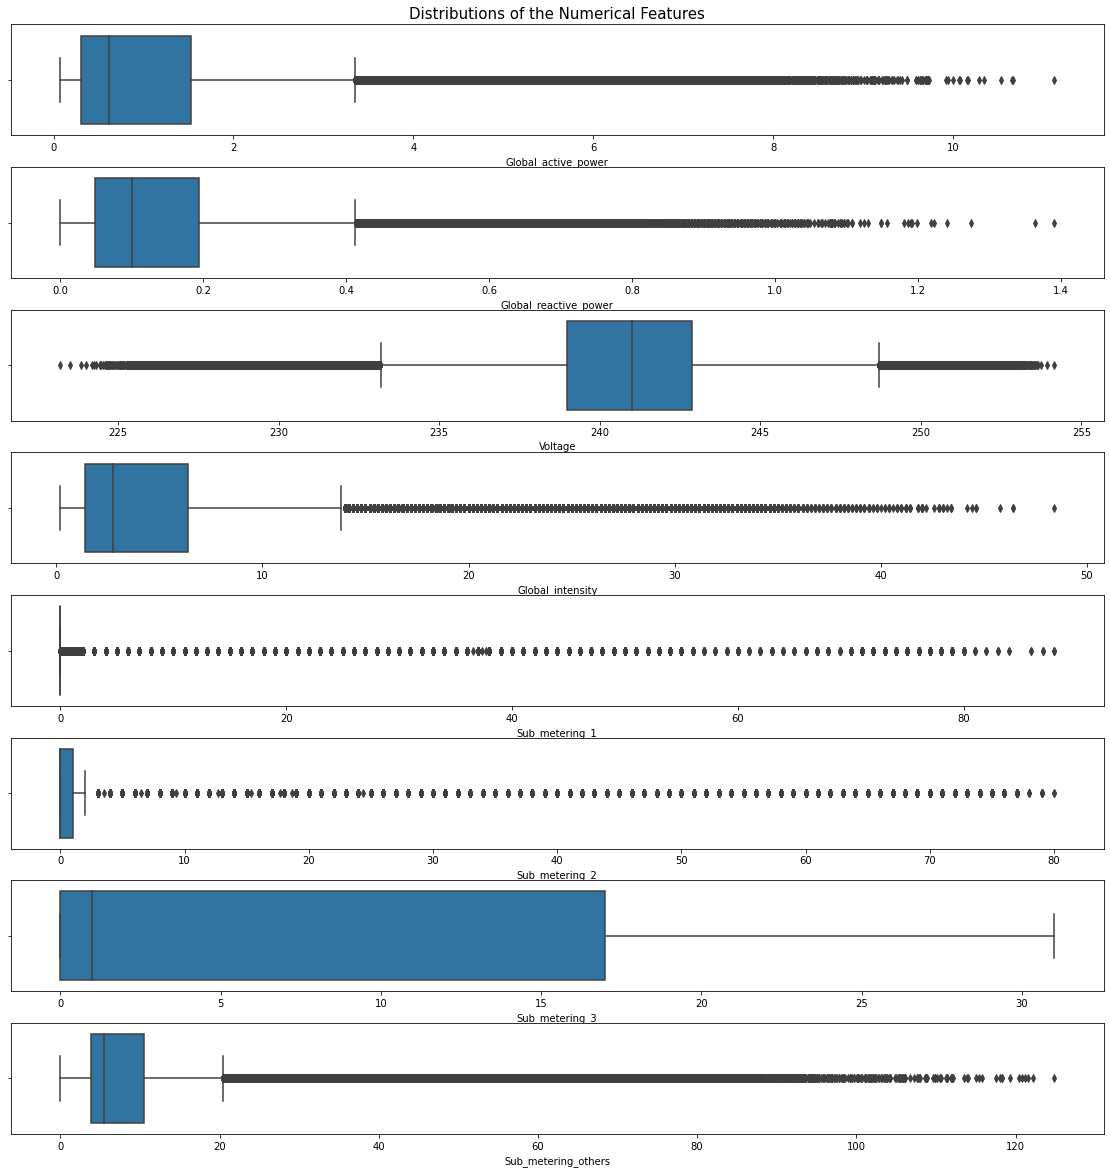

In [22]:
# Plot the box plots of prediction results of all models
fig, ax = plt.subplots(nrows=len(num_features), ncols=1, figsize=(16,16))
fig.tight_layout()
                       
for n in range(len(num_features)):
    sns.boxplot(ax = ax[n], x=hpc_imputed[num_features[n]])

ax[0].set_title('Distributions of the Numerical Features', fontsize=15)

plt.show()

- All the numerical features indicates some variance, indicting potentials for modeling if desired.

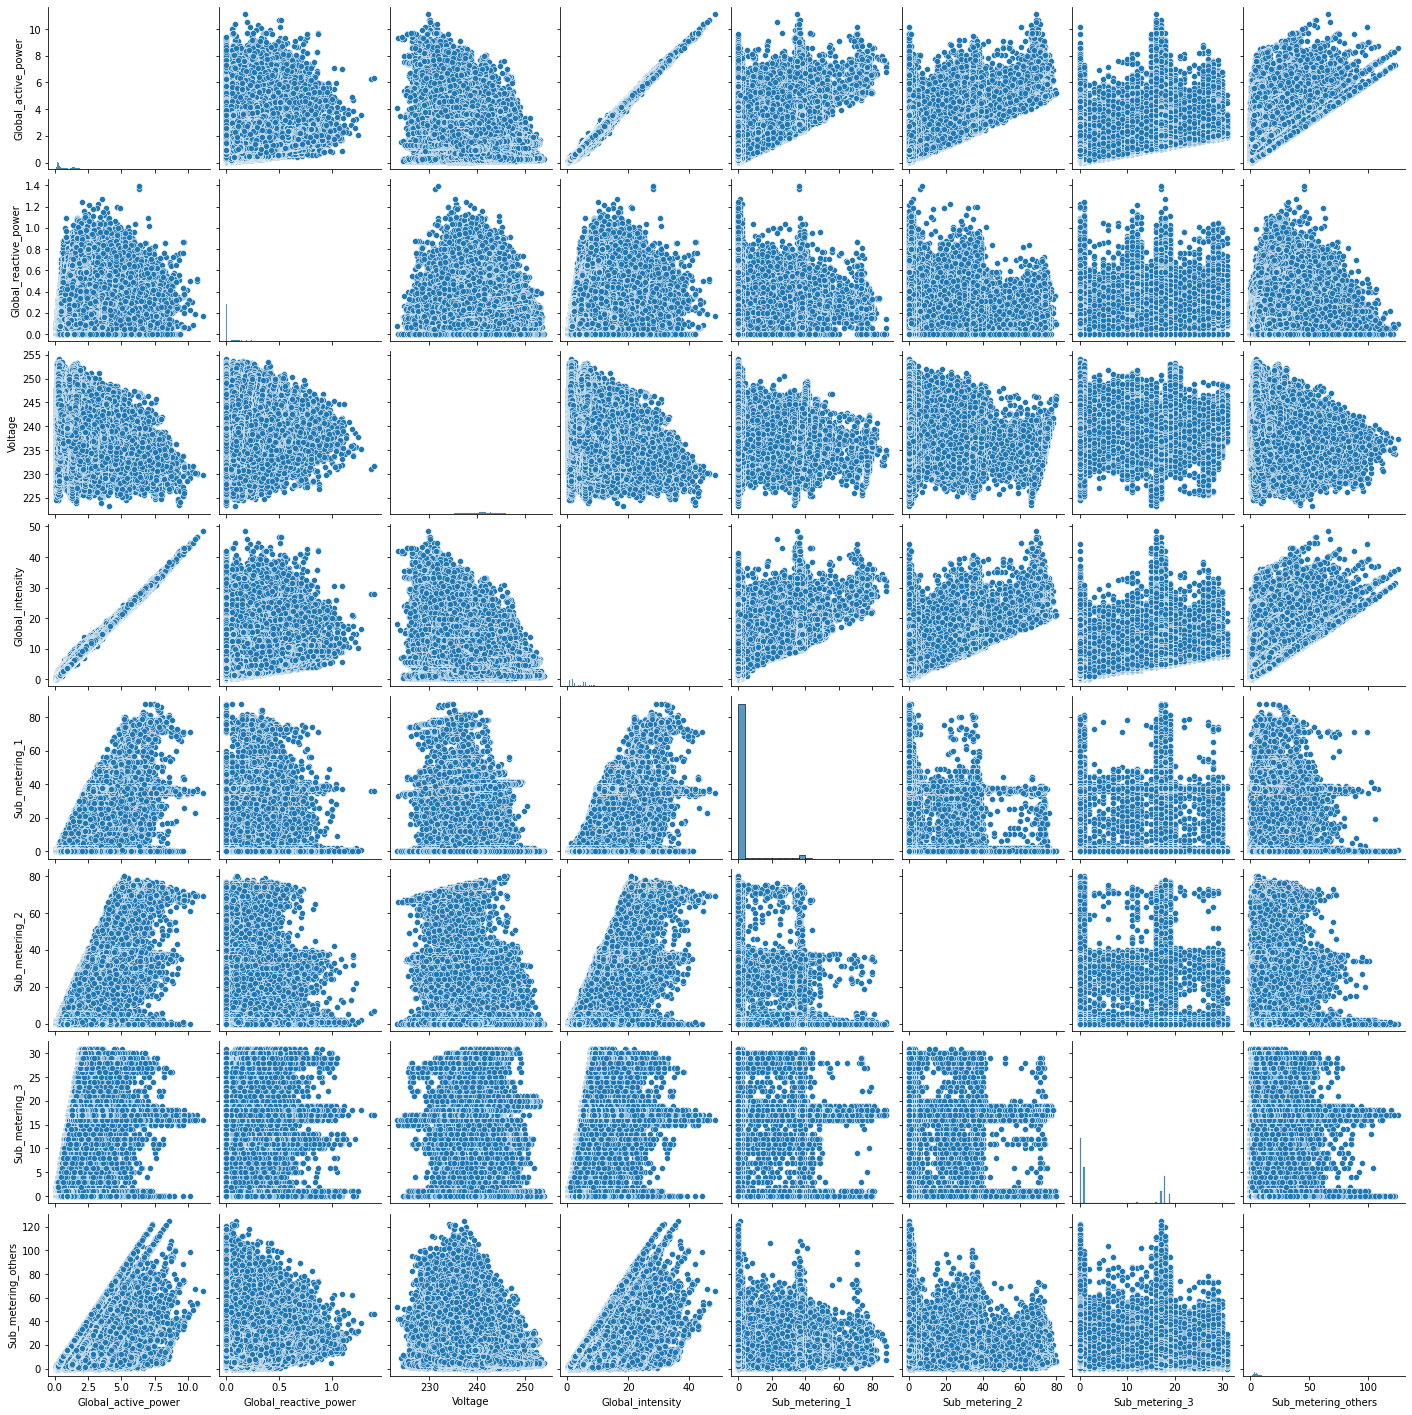

In [23]:
#Check correlations between the numerical features
num_pair_plot = sns.pairplot(hpc_num)
plt.show()

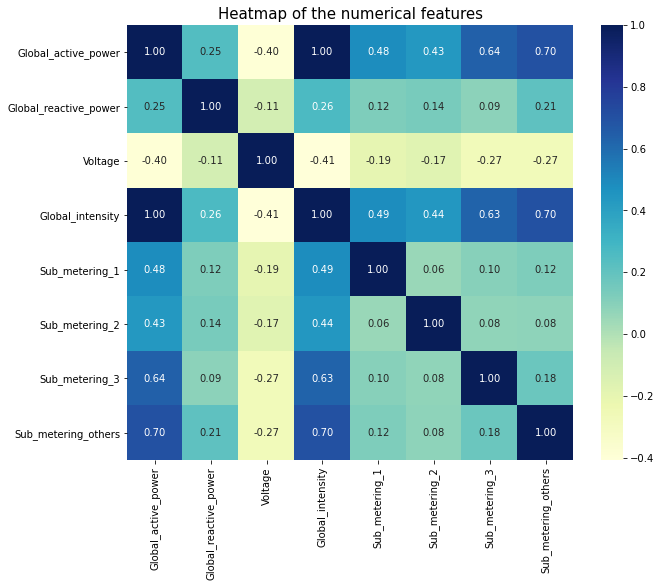

In [24]:
# Visualize the heat map
plt.figure(figsize = (10,8))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
sns.heatmap(hpc_num.corr(),annot=True,fmt='.2f',cmap="YlGnBu")
plt.title('Heatmap of the numerical features', fontsize=15)
plt.show()

**Part Summary**
- According to the heat map and pairplot, the `Global_active_power` exhibites perfect correlation (rho = 1) with `Global_intensity`, namely colinerity, which is reasonable as **power = voltage * current**.

- Though `Voltage` shows minimal variance (239 V [25% percentile] to 243 V [75% percentile]) of voltage during the whole period; its observable negtive correlations (rho = -0.4) with `Global_active_power` makes sense, since a higher power usage can lead to the voltage drop due to circuit loss. Imagine when turning on high power facility such as AC, light usally dims due to voltage drop.

- `Global_active_power` indicates strong correlations (rho > 0.43) with `Sub_metering_1`, `Sub_metering_2`, `Sub_metering_3`, and `Sub_metering_others`, as it is the sum of these four. From the correlation values, we may get the idea that `Sub_metering_3` and `Sub_metering_others` contribute more to `Global_active_power`, which make sense as `Sub_metering_3` corresponds to an electric water-heater and an air-conditioner, which are energy intensive but regularly used in house, especially in winter.  

- As for the correlations among the four energy sinks, they demonstrated negligible relationships as they are generally used separately without affecting others much. 

## 2.2 Time features processing and visualization

### **(1) Time Series**

In [25]:
# Create a new DataFrame with all DataTime as index
hpc_time = pd.DataFrame()
hpc_time = hpc_num.loc[:]

# create a new dataframe with delivery duration as the data, and time as the index
hpc_time.index = pd.to_datetime(hpc_imputed.DateTime)

# Add data time features, such as year, month and day 
hpc_time['Year'] =  hpc_time.index.year
hpc_time['Month'] =  hpc_time.index.month
hpc_time['Day'] =  hpc_time.index.day
hpc_time['Hour'] =  hpc_time.index.hour
hpc_time['Weekday'] =  hpc_time.index.weekday

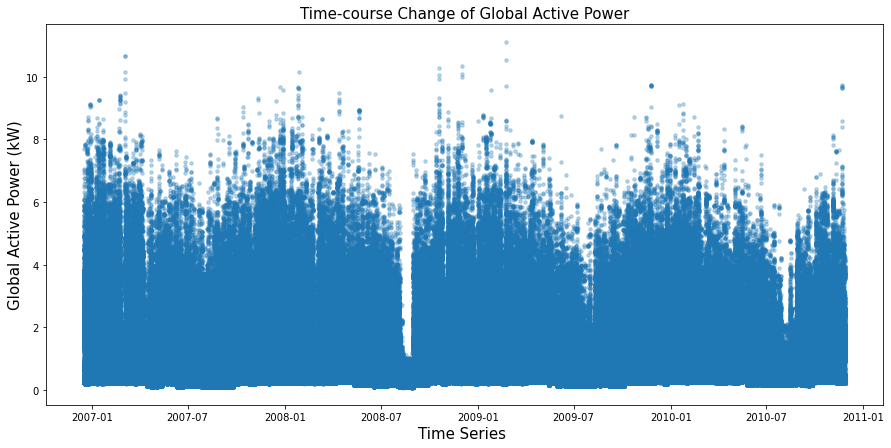

In [26]:
#plot the time series data
plt.figure(figsize = (15,7))
plt.scatter(hpc_time.index, hpc_time.Global_active_power, s=12, alpha=0.3)
plt.title('Time-course Change of Global Active Power', fontsize=15)
plt.xlabel('Time Series ', fontsize=15)
plt.ylabel('Global Active Power (kW)', fontsize=15)
plt.show()

**Part Summary**
- The global active power varies greatly in min level, which can either spike to ~12 kW in a short period time, or drop to 0 kW and maitain for a long while. 

- The time series plot in minute level is noisy and present unobservable patterns; aggregation is needed to catch patterns. 

### **(2) Resample and Rolling (Active Power, kW)**<br> 

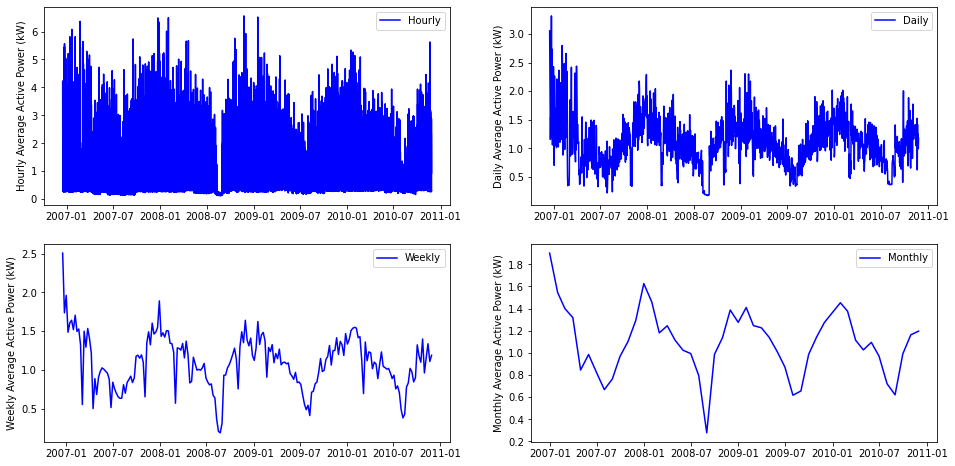

In [27]:
#Plot rolling average global active power 
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16,8))

axes[0][0].plot(hpc_time.Global_active_power.resample('H').mean(), 'b-')
axes[0][1].plot(hpc_time.Global_active_power.resample('D').mean(), 'b-')
axes[1][0].plot(hpc_time.Global_active_power.resample('W').mean(), 'b-')
axes[1][1].plot(hpc_time.Global_active_power.resample('M').mean(), 'b-')

axes[0][0].set_ylabel('Hourly Average Active Power (kW)')
axes[0][1].set_ylabel('Daily Average Active Power (kW)')
axes[1][0].set_ylabel('Weekly Average Active Power (kW)')
axes[1][1].set_ylabel('Monthly Average Active Power (kW)')

axes[0][0].legend(['Hourly'], loc="best")
axes[0][1].legend(['Daily'], loc="best")
axes[1][0].legend(['Weekly'], loc="best")
axes[1][1].legend(['Monthly'], loc="best")

plt.show()

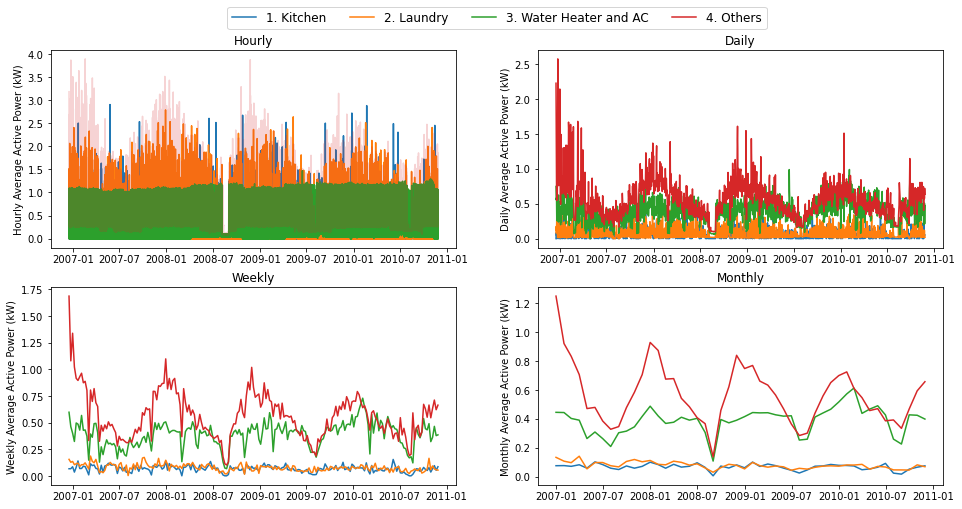

In [28]:
#Plot rolling average global active power 

time_series = [['H', 'D'], ['W', 'M']]
sub_meters = ['1. Kitchen','2. Laundry', '3. Water Heater and AC', '4. Others']

def plot_time_feature(df, features):
    row = len(features)
    col = 2
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16,8))
    
    for i in range(2):
        for j in range(2): 
            alpha = 1
            if i == 0 and j == 0:
                alpha = 0.2
            axes[i][j].plot(hpc_time.Sub_metering_1.resample(time_series[i][j]).mean()*60/1000)
            axes[i][j].plot(hpc_time.Sub_metering_2.resample(time_series[i][j]).mean()*60/1000)
            axes[i][j].plot(hpc_time.Sub_metering_3.resample(time_series[i][j]).mean()*60/1000)
            axes[i][j].plot(hpc_time.Sub_metering_others.resample(time_series[i][j]).mean()*60/1000, alpha = alpha)

    axes[0][0].set_ylabel('Hourly Average Active Power (kW)')
    axes[0][1].set_ylabel('Daily Average Active Power (kW)')
    axes[1][0].set_ylabel('Weekly Average Active Power (kW)')
    axes[1][1].set_ylabel('Monthly Average Active Power (kW)')
    
    axes[0][0].set_title('Hourly')
    axes[0][1].set_title('Daily')
    axes[1][0].set_title('Weekly')
    axes[1][1].set_title('Monthly')
    
    axes[0][1].legend(sub_meters, loc="upper center", ncol=4, bbox_to_anchor=(-0.1, 1.25), fontsize=12)

plot_time_feature(hpc_time, time_series)
plt.show()


**Part Summary**
- The time series plot of active power in hour level is still noisy and present unobservable patterns. However, it can be seen that the power of Water Heater and AC (sub_metering_3) is realatively stable than the others, such as Kitchen, Laundry, and other can spike active power up to ~3, ~2.5 and ~4 kW. 

- The power patters are more clear when aggregated daily, weekly and monthly. Since the data only covered 4 years, the year pattern is not shown here. In overall, Kitchen and Landry contribute steady power in weekly and monthly aspect. 

- This is very differently from `Water Heater and AC` and `Others`, and the overall `Global_active_power`, who demonstrate seasonal patterns and greatly depend on the months, which is high in winter and lower in summer with big differece. Intuatively, the results are not reasonable as summer can be hot and where AC can be intensively used. However, very differently from the US, where AC is very commonly used in summer, the historical weather data of Paris indicates that Sceaux (7km of Paris, France) is comfortable in summer (12-25 oC) during which AC is not neccessary. In winter when temperature can be as low as 5 oC, power consumption is high which can be due to the intensive use of electric water-heater and air conditioner. 

- It is interesting to note that there observed some sharp dips in Month 8 lasting several days. It might be due to travel where no one is at home?  

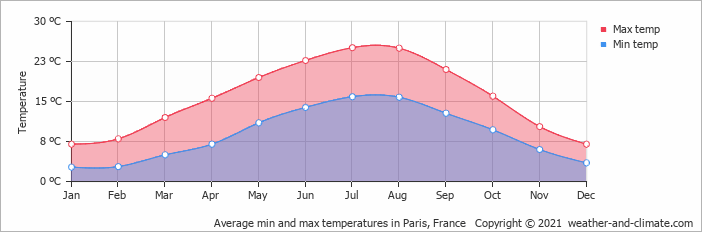

### **(3) Resample and Rolling (Active Energy Consumption, kWh)**<br> 

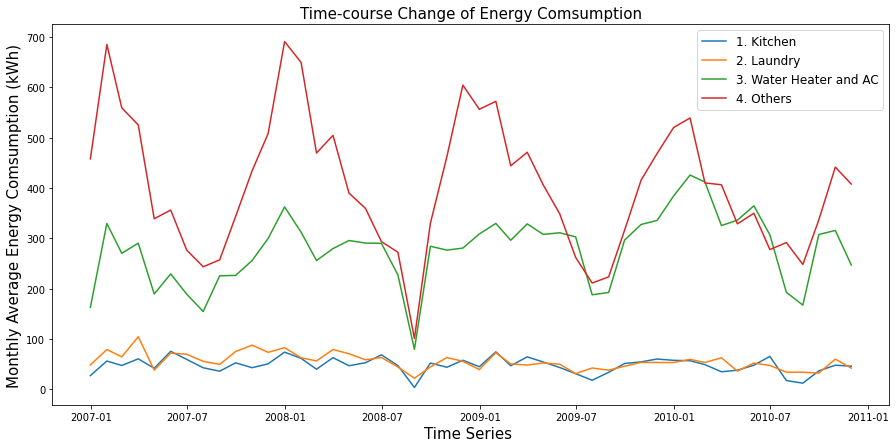

In [29]:
#plot the time series data
plt.figure(figsize = (15,7))
plt.plot(hpc_time.Sub_metering_1.resample('M').sum()/1000)
plt.plot(hpc_time.Sub_metering_2.resample('M').sum()/1000)
plt.plot(hpc_time.Sub_metering_3.resample('M').sum()/1000)
plt.plot(hpc_time.Sub_metering_others.resample('M').sum()/1000)

plt.title('Time-course Change of Energy Comsumption', fontsize=15)
plt.xlabel('Time Series ', fontsize=15)
plt.ylabel('Monthly Average Energy Comsumption (kWh)', fontsize=15)

plt.gca().legend(('1. Kitchen','2. Laundry', '3. Water Heater and AC', '4. Others'), fontsize=12)

plt.show()

**Part Summary**
- Similar to the time series plot of `Global_active_power`, the time series plots for all four utility cateories are still noisy and present unobservable patterns at hourly, daily and weekly. Therefore, only monthly plots is shown here. 

- It clear in the monthly average power consumption (kWh) chart shows very similar trend like the `Global_active_power`, and depends on the months. 

- Kitchen and landry contribute miminal to the overall power usage. In the last part, it is suggested that water heater and AC affected much by season, which is high in winter and lower in summer with big differece, should weigh a lot much than the others. However, it is not true, especially in winter (Months 1 - 3), when the other utilities can contribute up to 65%. Therefore, it is necessary to figure out the details in this category. 

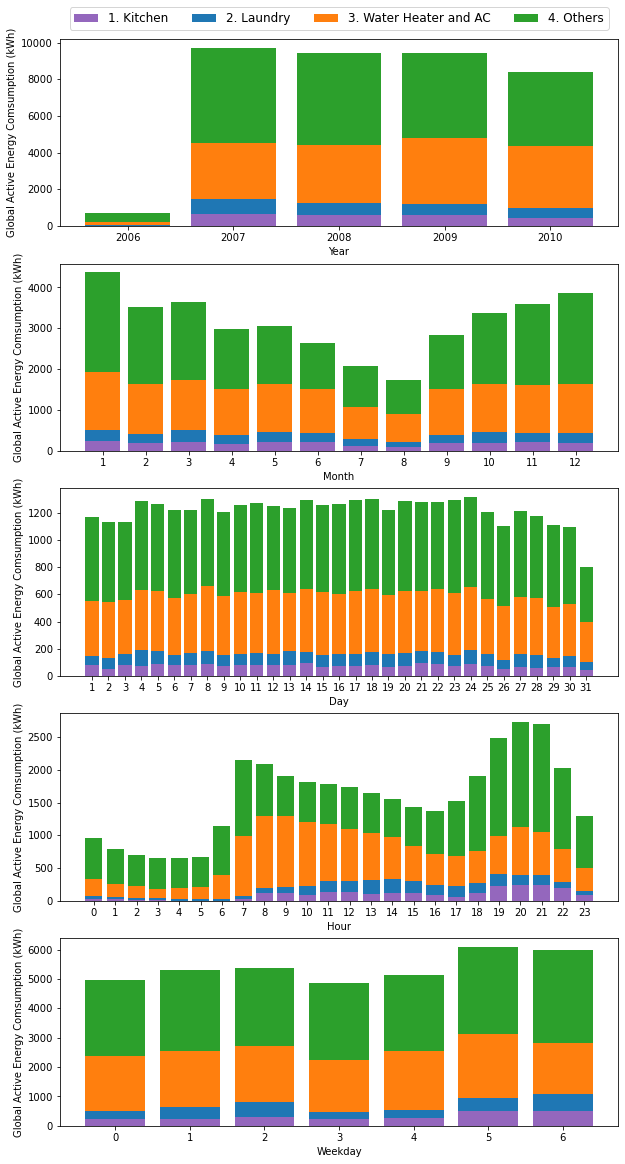

In [30]:
# Plot average Global_active_power vs data features 
time_features = ['Year', 'Month', 'Day', 'Hour', 'Weekday']
# sub_meters = ['sub_meter_1: Kitchen','sub_meter_2: Laundry', 'sub_meter_3: Water Heater and AC', 'Others']
sub_meters = ['1. Kitchen','2. Laundry', '3. Water Heater and AC', '4. Others']

def plot_time_feature(df, features):
    row = len(features)
    col = 1
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(10,4*row))
    
    for i, f in enumerate(features):
        
        ax[i].bar(df.groupby(f)['Sub_metering_1'].groups.keys(),
            df.groupby(f)['Sub_metering_1'].sum()/1000,
                  width=0.8, align='center', color= '#9467bd')
        
        ax[i].bar(df.groupby(f)['Sub_metering_2'].groups.keys(),
            df.groupby(f)['Sub_metering_2'].sum()/1000,
                  width=0.8, align='center', 
                  bottom=df.groupby(f)['Sub_metering_1'].sum()/1000)
        
        ax[i].bar(df.groupby(f)['Sub_metering_3'].groups.keys(),
            df.groupby(f)['Sub_metering_3'].sum()/1000,
                  width=0.8, align='center', 
                  bottom=df.groupby(f)['Sub_metering_1'].sum()/1000+df.groupby(f)['Sub_metering_2'].sum()/1000)
        
        ax[i].bar(df.groupby(f)['Sub_metering_others'].groups.keys(),
            df.groupby(f)['Sub_metering_others'].sum()/1000,
                  width=0.8, align='center', 
                  bottom=df.groupby(f)['Sub_metering_1'].sum()/1000+df.groupby(f)['Sub_metering_2'].sum()/1000+df.groupby(f)['Sub_metering_3'].sum()/1000)

        
        ax[i].set_xlabel(f)
        ax[i].set_ylabel('Global Active Energy Comsumption (kWh)')
    ax[0].legend(sub_meters, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.2), fontsize=12)
    ax[1].set_xticks(np.linspace(1,12,12))
    ax[2].set_xticks(np.linspace(1,31,31))
    ax[3].set_xticks(np.linspace(0,23,24))

plot_time_feature(hpc_time, time_features)
plt.show()

**Part Summary**
- The yearly electricity consumption is stable with a trend of minimal decline (More years of data may needed to confirm such conclusion). 

- Electricity consumption depends highly on months, with decline trend from Spring to Summer (Month 1 - 8) but increase trend from Autumn to Winter (Month 9 - 1). This corresponds the previous seasonal power analysis. 

- There is no clear pattern in daily basis. 

- Different from the time series plot, the hourly aggregation indicates very clear patterns. It can be seen that the household is more active from 7 AM to 11 PM, especially at meal time (breakfast: 7-8 AM, and dinner: 6-9 PM). 

- The electricity consumption is higher on Saturday and Sunday, which is reasonable, as at the time, people stay more at home, do more cooking and use more utilities at home, either heating or AC or others. 

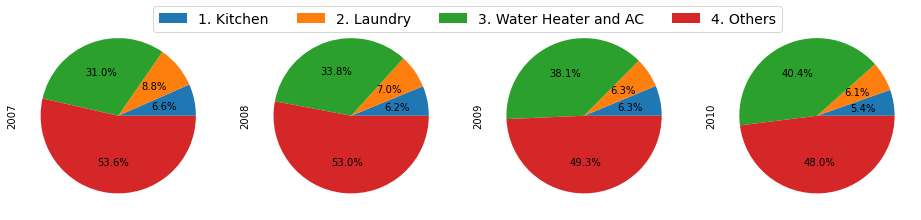

In [31]:
#Plot the contributions of each category to the total power comsumption
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(16,10))

axes[0].pie(hpc_time.groupby('Year')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_others'] ].sum().loc[2007, :], autopct='%1.1f%%')
axes[1].pie(hpc_time.groupby('Year')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_others'] ].sum().loc[2008, :], autopct='%1.1f%%')
axes[2].pie(hpc_time.groupby('Year')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_others'] ].sum().loc[2009, :],  autopct='%1.1f%%')
axes[3].pie(hpc_time.groupby('Year')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_others'] ].sum().loc[2010, :],  autopct='%1.1f%%')

axes[0].set_ylabel('2007')
axes[1].set_ylabel('2008')
axes[2].set_ylabel('2009')
axes[3].set_ylabel('2010')

plt.gca().legend(('1. Kitchen','2. Laundry', '3. Water Heater and AC', '4. Others'),
                loc="upper center", ncol=4, bbox_to_anchor=(-1.3, 1.1), fontsize=14)
fig.tight_layout()
plt.show()

**Part Summary**
- Since Years 2006 has only one month, it is not included here. 

- In overall, the contribution of each category is pretty stable, with ~7%, ~6%, ~35%  and ~50% for Sub_metering_1 (Kitchen), Sub_metering_2 (Laundry), Sub_metering_3 (Water heater and AC), and others. 

- It might be necessary to figure out the details of the equipment usage in the category of Others. 

# Part 3. Machine Learning Model

## 3.1 Model selection and comparison

Since the data set has been cleaned and organized, except the time feature, there is no need to build data transformers for data transformation.

### **(1) Model Selection and Rationale**<br>

- Predicting the electric power consumption can be useful not only for the household users itself, but the data can also be used for some vendors, such as solar companies, to attract the customer installing their new services, such as solar panels, to reduce utility bills or even generate income. 

- In order to predict time series data, LSTM (long short-term memory network), a kind of recurrent neural networks (RNN) is employed, as it is capable of learning long-term dependencies from the input sequence. In addition to LSTM, ARIMA is another widely used model in  time series data prediction. But here, limited by time, it is not used and compared with LSTM. 

### **(2) Build Data Transformer**<br>

In [32]:
# Build the data transformer
class data_transformer():
    def __init__(self):
        None
          
    def featureGenerator(self, df, n):
        x, y = [], []
        for i in range(n, len(df)):
            y.append(df[i])
            x.append(df[i-n:i])
        x = pd.DataFrame(x)
        return x, y

    def fit(self, X, y=None):
        scaler = MinMaxScaler()
        X_new = scaler.fit_transform(X)
        X_new = X_new.reshape(1,len(X))[0]
        x, y = self.featureGenerator(X_new, 31)
        
    def transform(self, X, y= None):
        scaler = MinMaxScaler()
        X_new = scaler.fit_transform(X)
        X_new = X_new.reshape(1,len(X))[0]
        x, y = self.featureGenerator(X_new, 31)
        return x, y

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def train_test_valid_split(self, x, y, i, j):
        split_train = int(len(y) * i)
        split_test = int(len(y) * j)
        X_train, y_train = x[:split_train].values, y[:split_train]
        X_test, y_test = x[split_train:split_test].values, y[split_train:split_test]
        X_valid, y_valid = x[split_test:].values, y[split_test:]
        
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

        X_train, y_train = np.asarray(X_train), np.asarray(y_train)
        X_test, y_test = np.asarray(X_test), np.asarray(y_test)
        X_valid, y_valid = np.asarray(X_valid), np.asarray(y_valid)
        
        return X_train, y_train, X_test, y_test, X_valid, y_valid

### **(3) Data Transforming**<br>

In [33]:
# Creat new DataFrames, including Global_active_energy, kWh. 
gap_df = pd.DataFrame(hpc_time.Global_active_power.resample('D').sum()/60)

# Data Preprocessing (transform first, split second)
dt = data_transformer()
x, y = dt.fit_transform(gap_df)

### **(4) Data Splitting**<br>

Train (60%), test (20%) and valid (20%) are chosen for data spliting and modeling

In [34]:
# split the data to train, test and validate
X_train, y_train, X_test, y_test, X_valid, y_valid = dt.train_test_valid_split(x, y, 0.6, 0.8)

In [35]:
#Check data spliting 
print(X_train.shape, len(y_train), X_test.shape, len(y_test), X_valid.shape, len(y_valid))

(846, 31, 1) 846 (282, 31, 1) 282 (283, 31, 1) 283


### **(5) Modeling Development and Prediction**<br>

In [36]:
#Build RNN model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_lstm.add(Dropout(0.4))
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.4))
model_lstm.add(LSTM(units=50, return_sequences = True))
model_lstm.add(Dropout(0.4))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='rmsprop', loss='mean_squared_error')

out = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
27/27 [==============================] - 10s 209ms/step - loss: 0.0256 - val_loss: 0.0077
Epoch 2/50
27/27 [==============================] - 5s 193ms/step - loss: 0.0176 - val_loss: 0.0081
Epoch 3/50
27/27 [==============================] - 8s 298ms/step - loss: 0.0183 - val_loss: 0.0074
Epoch 4/50
27/27 [==============================] - 5s 191ms/step - loss: 0.0178 - val_loss: 0.0072
Epoch 5/50
27/27 [==============================] - 5s 190ms/step - loss: 0.0172 - val_loss: 0.0096
Epoch 6/50
27/27 [==============================] - 5s 191ms/step - loss: 0.0165 - val_loss: 0.0126
Epoch 7/50
27/27 [==============================] - 5s 190ms/step - loss: 0.0168 - val_loss: 0.0072
Epoch 8/50
27/27 [==============================] - 5s 189ms/step - loss: 0.0155 - val_loss: 0.0086
Epoch 9/50
27/27 [==============================] - 5s 190ms/step - loss: 0.0166 - val_loss: 0.0068
Epoch 10/50
27/27 [==============================] - 5s 190ms/step - loss: 0.0167 - val_loss: 0.010

In [37]:
#LMST prediction
y_train_pred = model_lstm.predict(X_train)
y_test_pred = model_lstm.predict(X_test)
y_valid_pred = model_lstm.predict(X_valid)

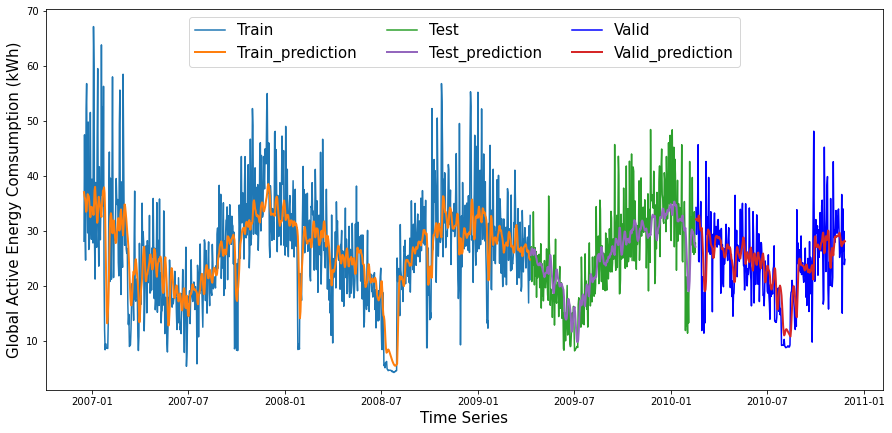

In [38]:
#Plot the train, test, valid and their predictions
split_train = int(len(y) * 0.6)
split_test = int(len(y) * 0.8)

scaler = MinMaxScaler()
scaler.fit(gap_df)

plt.figure(figsize = (15,7))
predict = np.concatenate((scaler.inverse_transform(y_train_pred), scaler.inverse_transform(y_test_pred), \
               scaler.inverse_transform(y_valid_pred)), axis = 0)
output = pd.DataFrame()
output['predict'] = np.reshape(predict, (1, len(x)))[0]
output['original'] = scaler.inverse_transform(np.array(y).reshape(1,len(x)))[0]

# output['DateTime'] = pd.Series(avg_df.index[:1441])
plt.plot(pd.Series(gap_df.index[:split_train]), output.original[:split_train])
plt.plot(pd.Series(gap_df.index[:split_train]), output.predict[:split_train], linewidth=2)

plt.plot(pd.Series(gap_df.index[split_train:1442-len(y_valid)]),output.original[split_train:1442-len(y_valid)])
plt.plot(pd.Series(gap_df.index[split_train:1442-len(y_valid)]),output.predict[split_train:1442-len(y_valid)], linewidth=2, color= '#9467bd')

plt.plot(pd.Series(gap_df.index[1442-len(y_valid):]),output.original[split_test:], color='b')
plt.plot(pd.Series(gap_df.index[1442-len(y_valid):]),output.predict[split_test:], linewidth=2)

plt.gca().legend(('Train','Train_prediction', 'Test', 'Test_prediction', 'Valid', 'Valid_prediction',),
                loc="upper center", ncol=3, fontsize=15)

plt.ylabel('Global Active Energy Comsumption (kWh)', fontsize=15)
plt.xlabel('Time Series', fontsize=15)
plt.show()

### **(6) Train and Test Loss**<br>

In [39]:
# Build a data frame showing the tran and test loss of the model
LSTM_Loss = pd.DataFrame({'model': 'LSTM_epochs_50_batch_size_32',
                         'train_MAE':mean_absolute_error(y_train, y_train_pred),
                         'test_MAE':mean_absolute_error(y_test, y_test_pred),
                          'valid_MAE':mean_absolute_error(y_valid, y_valid_pred),
                         'train_MSE':mean_squared_error(y_train, y_train_pred),
                         'test_MSE':mean_squared_error(y_test, y_test_pred),
                          'valid_MAE':mean_squared_error(y_valid, y_valid_pred),
                         'train_R2':r2_score(y_train, y_train_pred),
                         'test_R2':r2_score(y_test, y_test_pred), 
                         'valid_R2':r2_score(y_valid, y_valid_pred)},index=[0])
LSTM_Loss

,model,train_MAE,test_MAE,valid_MAE,train_MSE,test_MSE,train_R2,test_R2,valid_R2
0,LSTM_epochs_50_batch_size_32,0.079145,0.059796,0.006197,0.011187,0.005978,0.418611,0.582934,0.364571


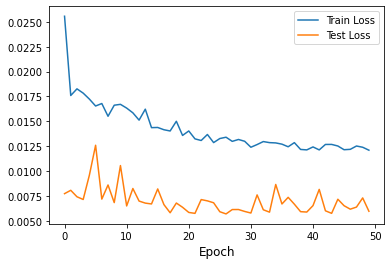

In [40]:
# plot the validation loss in training
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.gca().legend(('Train Loss','Test Loss'))
plt.xlabel('Epoch', fontsize=12)
plt.show()

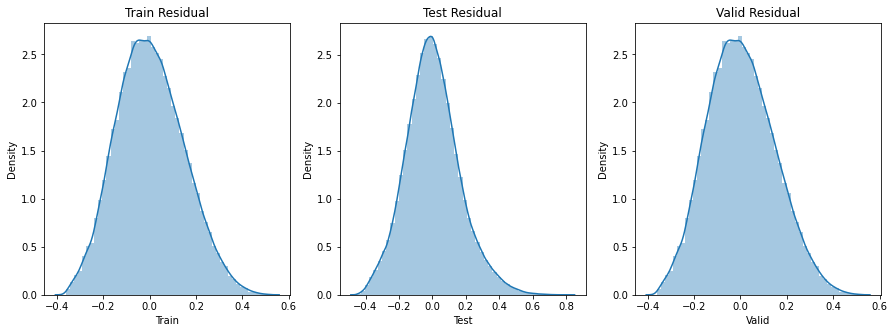

In [41]:
#Residule plot check
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5))

res_train = y_train-y_train_pred
res_test = y_test-y_test_pred
res_valid = y_test-y_test_pred


sns.distplot(res_test, ax=axes[0])
axes[0].set(xlabel="Train", ylabel="Density", title = 'Train Residual')

sns.distplot(res_train,ax=axes[1])
axes[1].set(xlabel="Test", ylabel="Density", title = 'Test Residual')

sns.distplot(res_valid,ax=axes[2])
axes[2].set(xlabel="Valid", ylabel="Density", title = 'Valid Residual')

plt.show()

In [42]:
#Clean GPU memory
from numba import cuda
cuda.select_device(0)
cuda.close()

**Part Summary**
- The prediction curves simulates the major patterns of the ground truth, though spikes are normally ignored. 

- From the score table, it is clear to see that the bias and variance for LSTM model are acceptable. 

- The residule plots with nomal distributions evidence good results for modeling. 

- In order to reduce the variance, the LSTM model will be tuned in the next step.

## 3.2 Model hyperparameter tuning

RandomSearchCV and GridSearchCV are the most widely used hyperparameter tuning methods. The first one can be used to narrow down the range for each hyperparameter, while GridSearchCV is employed here fore hyperparameters tuning. However, since they are not compatiable with Keras as Keras `Sequential` model does not implement a 'get_params' method. Therefore, we manually tune this model. Due to the large data set and low computing power of my own server, limited hyperparameters are tuned, including `epochs`, `batch_size`. 

**Due to Jupyter Notebook crash with the second running of LSTM, the tuning code is not run but markdown with only final results shown below.**

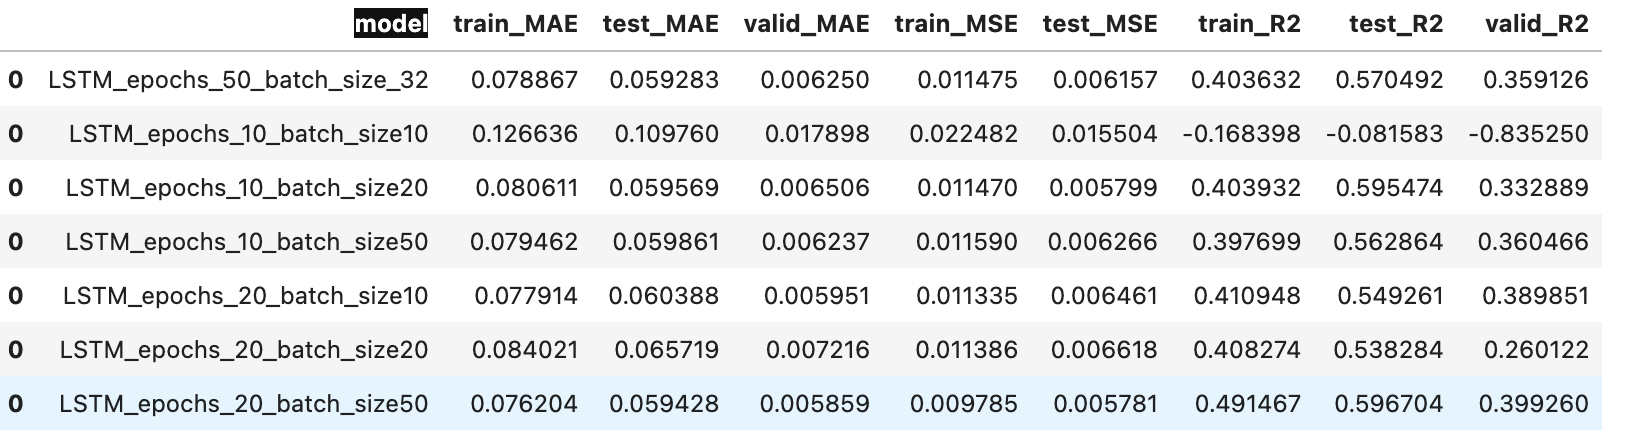

**Part Summary**
- Tuning `epochs` and `batch_size` can be time comsuming. Therefore, limited numbers are used for tuning. 

- In this easy tuning process, it is found that the best parameters are: {epochs = 20, batch_size =  50}, which reduced the variance (6.1% reduction in test MSE) and improved test R2 by 4.6%. 

- Since the variance after tune is still high, better server with better computation power may be employed for fine tuning and better performance.

# Part 4. Project Summary

In this project, an individual household electric power consumption is analyzed and predicted using deep learning (i.e., LSTM, RNN)

Before analysis and modeling, the raw data as checked, cleaned and imputed via linear interpolation. It can be seen in the following figures that power comsumption, including the global and sub_meters varies. And the historical aggregates demonstrates clearer trends, especially in hourly and monthly, which is closely affected by human activity and seasons. 

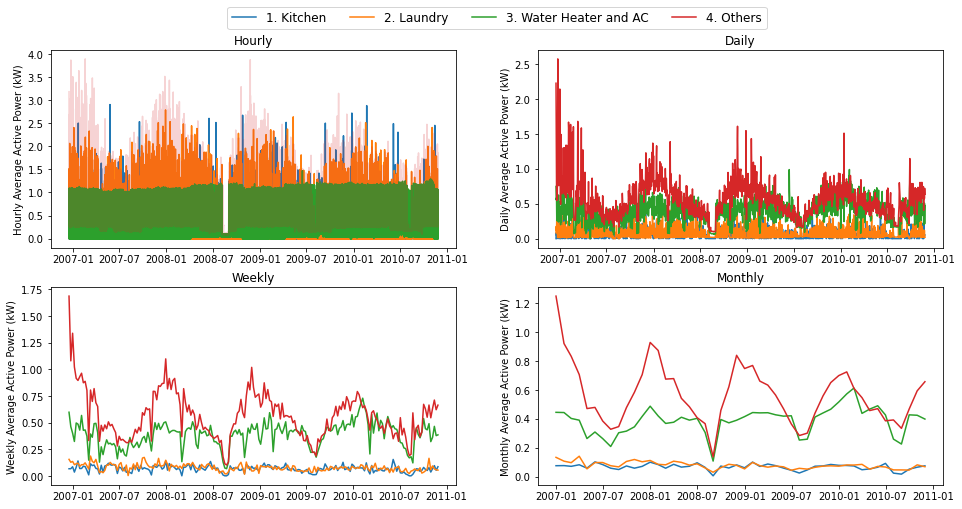
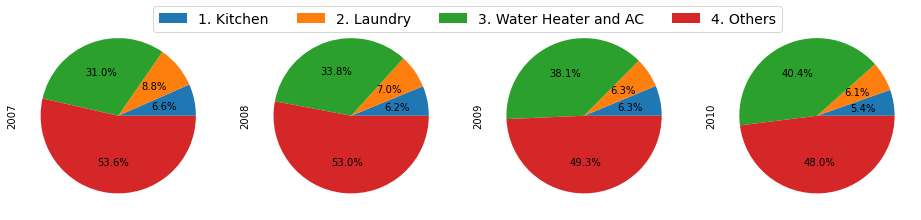

As for the modeling, LSTM, a RNN model, is employed and tuned. Its performance on the training and test before and after tuning is summerized below:

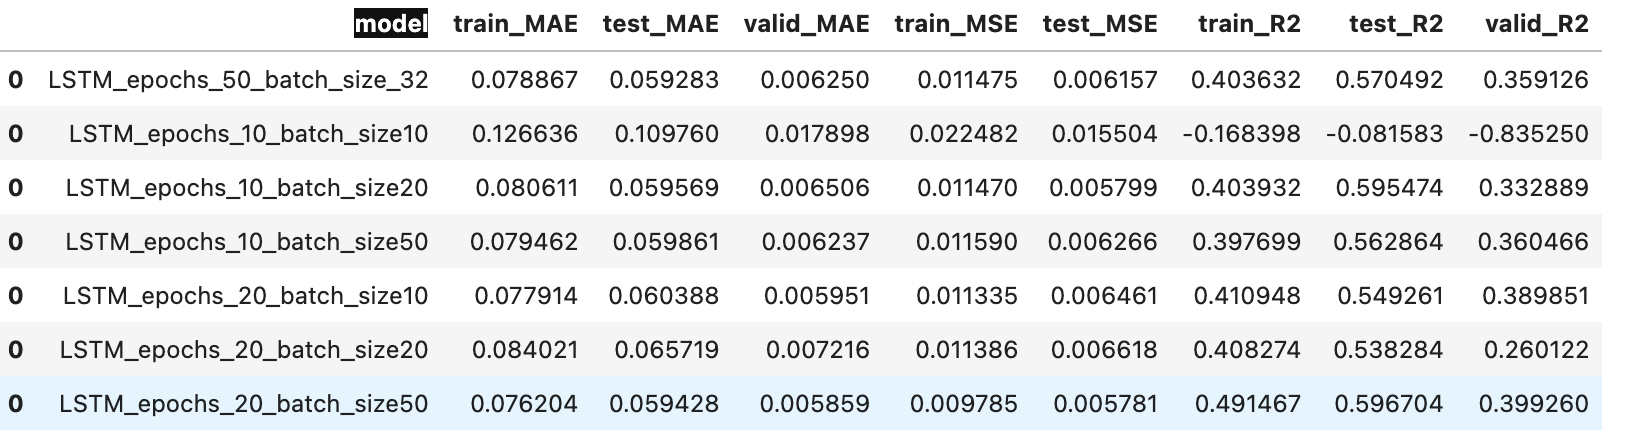
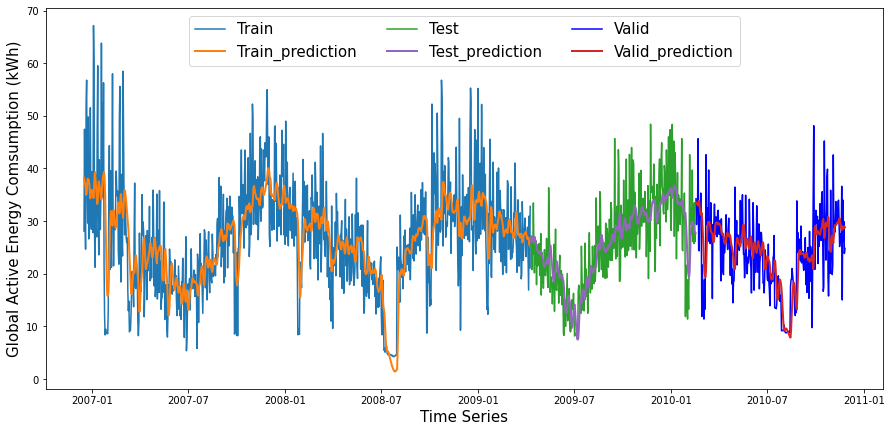

The prediction curves simulates much of the patterns of the ground truth, though spikes are noramlly ignored. And the results are supported by the bias and variance as well as the distribution of residules. Though the results look good and reasonable, from the loss table, the bias is still high, fine tunings may be needed. In addition to LSTM, ARIMA and GRU, the other two widely used models for time series prediction may also be used and compared. 

In [ ]:
#Clean GPU memory
from numba import cuda
cuda.select_device(0)
cuda.close()